In [1]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import trange
from sklearn import datasets

In [2]:
# Load Iris Dataset for Testing on Real Data

iris = datasets.load_iris()

A_iris = iris.data
Y_iris = iris.target

In [3]:
# Define Global Parameters

NUM_FEATURES = 1000
NUM_SAMPLES = 1000
NUM_CLASSES = 50

In [4]:
# Steps 1 and 2

A = np.random.randn(NUM_SAMPLES, NUM_FEATURES)

X = np.random.randn(NUM_FEATURES, NUM_CLASSES)
W = np.random.randn(NUM_FEATURES, NUM_CLASSES) # additional weight matrix

E = np.random.randn(NUM_SAMPLES, NUM_CLASSES)

# Even though we'll use X in algorithms, we won't use it in the initialization of B
B = A.dot(W) + E

In [5]:
Y = np.argmax(B, axis=1) 

# Y one-hot encoding
# Set maximum value of each row to 1 and others to 0
Y_oh = (B == B.max(axis=1, keepdims=1)).astype(int)

# Second version of one-hot encoding
Y_one_hot = np.zeros((NUM_SAMPLES, NUM_CLASSES))
Y_one_hot[np.arange(NUM_SAMPLES), Y] = 1

In [139]:
# an alternative way to calculate fisrt term of loss function using matrix multiplication 
T=A.dot(X)
T=T[np.arange(NUM_SAMPLES), Y]

In [6]:
# Define Multiclass Logistic Regression Loss Function
def loss(X,A):
    first_term = (A * X.T[Y]).sum(axis=-1)
    # asterisk is element-wise multiplication

    second_term = np.log(np.exp(A.dot(X)).sum(axis=-1))
    # dot product is matrix multiplication since we are doing it across all classes 

    return (-first_term + second_term).sum()
    # summing across all samples

In [7]:
def gradient(X,A):
    AX = A.dot(X)
    # just perform matrix multiplication one time to reduce complexity
    soft_max = np.exp(AX) / (np.exp(AX).sum(axis=-1, keepdims=True)+1e-4)
    # keepdims is used to keep the dimensions of X to align with Y_oh
    return A.T.dot(soft_max - Y_oh)
    #    final dimensions should be NUM_FEATURES x NUM_CLASSES 

In [8]:
# Create copy of X to test different gradient algorithms
X_GD = X.copy()
X_BCGD_R = X.copy()
X_BCGD_GS = X.copy()

In [143]:
# Step 3A: Gradient Descent

# Set parameters for gradient descent
max_iter = 500
# static learning rate for now
learning_rate = 0.001

losses = []
times = []
accuracies = []

start_time = time.time()

for i in trange(max_iter):
    # every iteration calculate gradient and update X
    X_GD -= learning_rate * gradient(X_GD)
    # calculate loss and accuracy every 1 iteration
    if i % 1 == 0:
        losses.append(loss(X_GD))
        times.append(time.time() - start_time)
        accuracies.append((Y == np.argmax(A.dot(X_GD), axis=1)).mean())

100%|██████████| 500/500 [00:12<00:00, 38.62it/s]


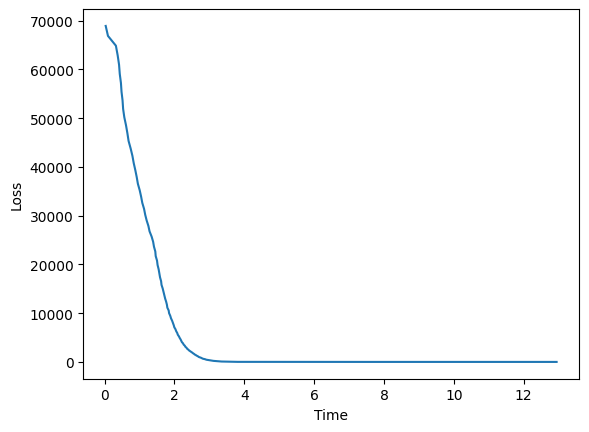

In [144]:
# synthetic dataset
plt.plot(times, losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

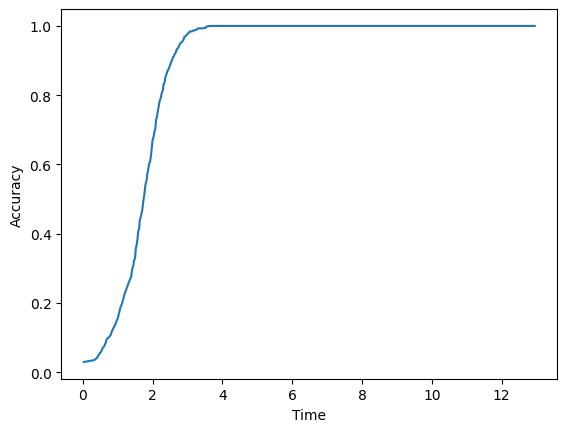

In [145]:
# synthetic dataset
plt.plot(times, accuracies)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

In [146]:
# Gradient for Block Coordinate Algorithms
# We define a block as a COLUMN of X, or a class
# Required params are weight matrix X and the block index

def gradient_bcgd(X, block):
    AX = A.dot(X)
    soft_max = np.exp(AX[:,block]) / (np.exp(AX).sum(axis=-1)+1e-4)
    # only calculate the softmax and gradient for the block
    return A.T.dot(soft_max - Y_oh[:,block])


In [147]:
# Step 3B: BCGD with Randomized Block Selection

# Set parameters for BCGD with Randomized Block Selection
max_iter = 500
learning_rate = 0.001

bcgd_r_losses = []
bcgd_r_times = []
bcgd_r_accuracies = []

start_time = time.time()

for i in trange(max_iter):
    # for every iteration, we iterate through all blocks to align with full gradient descent updates
    for j in range(NUM_CLASSES):
        # randomly select a block to update
        block = np.random.randint(0, NUM_CLASSES)
        # update the gradient just for the block
        X_BCGD_R[:, block] -= learning_rate * gradient_bcgd(X_BCGD_R, block)
    # append loss, time, accuracy 
    if i % 1 == 0:
        bcgd_r_losses.append(loss(X_BCGD_R))
        bcgd_r_times.append(time.time() - start_time)
        bcgd_r_accuracies.append((Y == np.argmax(A.dot(X_BCGD_R), axis=1)).mean())

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [02:19<00:00,  3.59it/s]


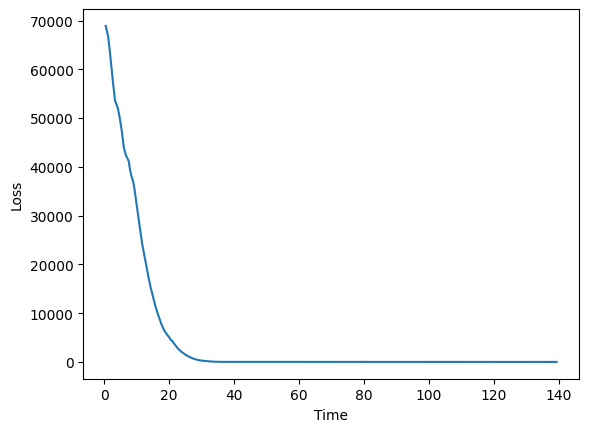

In [148]:
plt.plot(bcgd_r_times, bcgd_r_losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

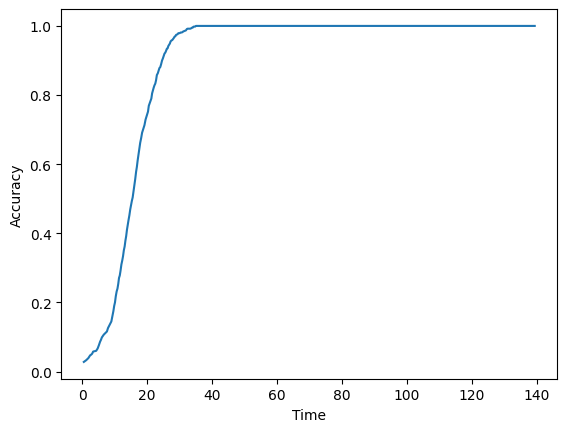

In [149]:
plt.plot(bcgd_r_times, bcgd_r_accuracies)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

In [52]:
# Step 3C: BCGD with GS Block Selection
X_BCGD_GS = X.copy()

# Gradient Descent
max_iter = 500
learning_rate = 0.001

bcgd_gs_losses = []
bcgd_gs_times = []
bcgd_gs_accuracies = []

unnormalized_prob = np.exp(A.dot(X_BCGD_GS)) # numerator
normalizer = unnormalized_prob.sum(axis=1, keepdims = True) # denominator

start_time = time.time()

for i in trange(max_iter,smoothing=0.):
    for j in range(NUM_CLASSES):
        grad = A.T.dot(unnormalized_prob/(normalizer+1e-4) - Y_oh)
        block = np.argmax(np.linalg.norm(grad, axis=0))
        block_grad = grad[:,block]
        pre_update = unnormalized_prob[:,block].copy()#to remmove it from the denominator and substitute the new part 
        X_BCGD_GS[:,block] -= learning_rate * block_grad
        unnormalized_prob[:,block] = np.exp(A.dot(X_BCGD_GS[:,block]))#we update the block in the matrix which contains the numerators of the softmax 
        #to avoid a full matrix multiplication 
        normalizer += unnormalized_prob[:,block,None] - pre_update[...,None]
        
    if i % 1 == 0:
        bcgd_gs_losses.append(loss(X_BCGD_GS))
        bcgd_gs_times.append(time.time() - start_time)
        bcgd_gs_accuracies.append((Y == np.argmax(A.dot(X_BCGD_GS), axis=1)).mean())


100%|██████████| 500/500 [02:05<00:00,  3.97it/s]


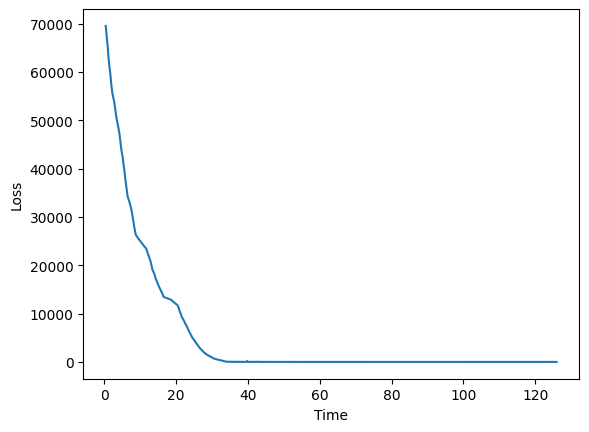

In [53]:
plt.plot(bcgd_gs_times, bcgd_gs_losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

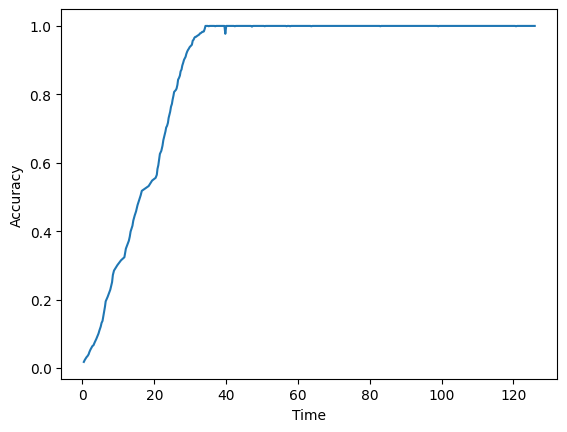

In [54]:
plt.plot(bcgd_gs_times, bcgd_gs_accuracies)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

## Implementation on real-life data 

In [9]:
np.random.seed(23)

iris = datasets.load_iris()

A_iris = iris.data
Y_iris = iris.target

#define dimensions for the real data 
num_samples=A_iris.shape[0]
num_features=A_iris.shape[1]
num_classes=len(np.unique(Y_iris))

#randomly generate the parameters matrix
X_iris = np.random.randn(num_features,num_classes)
W_iris = np.random.randn(num_features, num_classes) # additional weight matrix

E_iris = np.random.randn(num_samples, num_classes)

# Even though we'll use X in algorithms, we won't use it in the initialization of B
B_iris = A_iris.dot(W_iris) + E_iris


In [10]:
B_iris

array([[-4.01432613e+00, -3.05326954e-01, -1.62694578e+00],
       [-2.54766759e+00,  5.87879449e-01, -3.06968222e+00],
       [-2.48223172e+00,  1.04211233e+00, -6.62902179e-01],
       [-2.22796349e+00, -2.01348310e-01, -2.12010708e+00],
       [-6.89488409e+00,  8.32282416e-01, -6.67250843e-01],
       [-4.92761269e+00,  6.81404068e-01, -3.14346807e-01],
       [-3.79041422e+00,  1.03827331e+00, -1.07195376e+00],
       [-4.41590975e+00,  1.54398376e+00, -1.61344049e+00],
       [-4.29590133e+00, -2.12087865e-01, -1.55868768e+00],
       [-4.01411253e+00,  8.22863776e-01, -1.70339721e+00],
       [-4.87616325e+00, -9.72630412e-01, -9.79008629e-01],
       [-5.61130704e+00,  2.35805947e-01, -1.38495478e-01],
       [-3.70094353e+00, -4.59220933e-01, -1.11967068e+00],
       [-3.82953765e+00,  1.23294958e-01,  3.59332537e-03],
       [-3.49033964e+00,  4.28554723e+00, -2.69685224e+00],
       [-4.93552043e+00,  1.53253628e+00,  3.69267452e-01],
       [-4.42099173e+00,  2.63659989e+00

In [11]:
Y = np.argmax(B_iris, axis=1) 

# Y one-hot encoding
# Set maximum value of each row to 1 and others to 0
Y_oh = (B_iris == B_iris.max(axis=1, keepdims=1)).astype(int)

# Second version of one-hot encoding
Y_one_hot = np.zeros((num_samples, num_classes))
Y_one_hot[np.arange(num_samples), Y] = 1

In [14]:
gradient(X_GD_iris,A_iris)

array([[ 875.58260157, -657.28275037, -218.29992436],
       [ 457.97933269, -351.87942313, -106.09995207],
       [ 563.42857482, -398.12863329, -165.29997642],
       [ 179.85717789, -122.55719089,  -57.29999586]])

In [19]:
# Create copy of X to test different gradient algorithms
X_GD_iris = X_iris.copy()
X_BCGD_R_iris = X_iris.copy()
X_BCGD_GS_iris = X_iris.copy()

### Gradient Descent for real data

In [20]:
#  Gradient Descent

# Set parameters for gradient descent
max_iter = 5000
# static learning rate for now
learning_rate = 0.0005

losses = []
times = []
accuracies = []

start_time = time.time()

for i in trange(max_iter):
    # every iteration calculate gradient and update X
    X_GD_iris -= learning_rate * gradient(X_GD_iris, A=A_iris)
    # calculate loss and accuracy every 1 iteration
    if i % 1 == 0:
        losses.append(loss(X_GD_iris,A=A_iris))
        times.append(time.time() - start_time)
        accuracies.append((Y_iris == np.argmax(A_iris.dot(X_GD_iris), axis=1)).mean())

100%|██████████| 5000/5000 [00:01<00:00, 4028.76it/s]


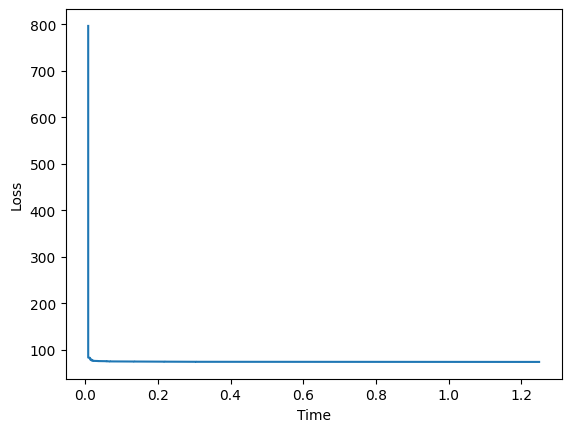

In [21]:
# real dataset
plt.plot(times, losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

In [22]:
losses[-1]

74.032121823182

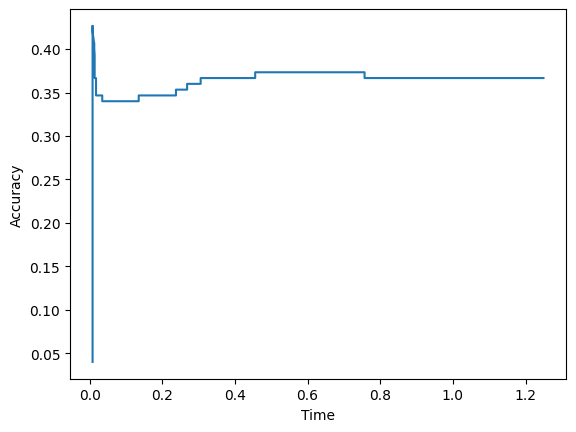

In [23]:
# real dataset
plt.plot(times, accuracies)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()